# Data Loading

In [21]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
paper_table = pd.read_csv('/data/sg/munjkim/USPTO/preprocessed/paper_table.csv')

/tmp/ipykernel_148382/2222392570.py:1: DtypeWarning: Columns (0,2,6,9,10,12,17,18,19,21,26,27,28,29,30,31,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  paper_table = pd.read_csv('/data/sg/munjkim/USPTO/preprocessed/paper_table.csv')


In [5]:

with open("../../ImpactofAI/data/g_gov_interest.tsv", 'r') as temp_f:
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

In [6]:
column_names = [i for i in range(0, max(col_count))]
government_interest = pd.read_csv("../../ImpactofAI/data/g_gov_interest.tsv", header=0, delimiter="\t")

In [16]:
government_interest_patent_id_set = set(government_interest['patent_id'])

In [7]:

#citation network
net = scipy.sparse.load_npz("/data/sg/munjkim/USPTO/preprocessed/citation_net.npz")
net.shape

(7387609, 7387609)

In [8]:
citations = np.array(net.sum(axis=0))[0]
references = np.array(net.sum(axis=1)).reshape((1,-1))[0]

In [9]:
paper_table['citations'] = paper_table['paper_id'].apply(lambda x: citations[x])
paper_table['references'] = paper_table['paper_id'].apply(lambda x: references[x])

In [10]:
edm_disruption = np.load('/data/sg/munjkim/USPTO/derived/original_1976_2020/100_5_q_1_ep_1_bs_65536_embedding/distance.npy')
disruption = np.load('/data/sg/munjkim/USPTO/derived/disruption.npy')
disruption_nok = np.load('/data/sg/munjkim/USPTO/derived/disruption_nok.npy')


In [11]:
paper_table['edm_disruption'] = paper_table['paper_id'].apply(lambda x: edm_disruption[x])
paper_table['disruption_nok'] = paper_table['paper_id'].apply(lambda x: disruption_nok[x])
paper_table['disruption'] = paper_table['paper_id'].apply(lambda x: disruption[x])

In [12]:
patent_table_significant = paper_table[(paper_table['citations']>4) & (paper_table['references']>0)]


In [13]:
patent_table_significant = patent_table_significant[patent_table_significant['year']>1978]
patent_table_significant = patent_table_significant[patent_table_significant['year']<2017]
patent_table_significant = patent_table_significant[patent_table_significant['type'] =='utility']


In [14]:
patent_table_significant['edm_disruption_percentile'] = patent_table_significant ['edm_disruption'].rank(pct=True)
patent_table_significant['disruption_percentile'] = patent_table_significant ['disruption'].rank(pct=True)

In [17]:
patent_table_significant_government_interest = patent_table_significant[patent_table_significant['patent_id'].apply(lambda x: str(x) in government_interest_patent_id_set)]




## Regression

In [ ]:
# patent_table_significant_regressions.to_csv('../data/patent_table_significant_regresions.csv',index=False)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_148382/3141008130.py:2: SyntaxWarning: invalid escape sequence '\D'
  variable_names =  ['D Percentile', '$\Delta$ Percentile','log(citations)']


<Figure size 1000x300 with 0 Axes>

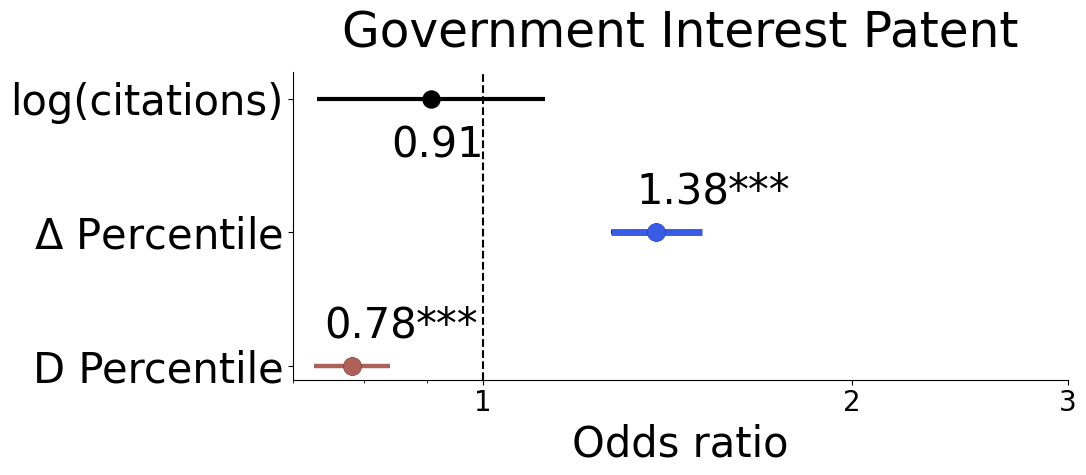

In [22]:

plt.figure(figsize = (10,3))
variable_names =  ['D Percentile', '$\Delta$ Percentile','log(citations)']
p_values = np.array([0.0, 1.754485e-07, 0.37])

# Determine significance levels

coef_edm_disruption = 0.32542139
se_edm_disruption = 0.04365276
coef_disruption = -0.24607341
se_disruption = 0.03663081
coef_log_citations = -0.09739707
se_log_citations = 0.10897188


alpha = 0.05
significance_levels = ['***' if p < alpha else '' for p in p_values]



# Extract odds ratios and confidence intervals
odds_ratios = np.exp( np.array( [coef_disruption ,  coef_edm_disruption, coef_log_citations] )  )
upper_limits = np.exp( np.array( [ coef_disruption+1.96 *se_disruption, coef_edm_disruption+ 1.96 *se_edm_disruption, coef_log_citations+1.96 *se_log_citations]))
lower_limits = np.exp(np.array([coef_disruption-1.96 *se_disruption,coef_edm_disruption- 1.96 *se_edm_disruption,coef_log_citations-1.96 *se_log_citations]))

average = ['***'  for p in odds_ratios]


plot_data = pd.DataFrame({'Odds Ratio': odds_ratios, 'Lower Limit': lower_limits, 'Upper Limit': upper_limits,'Significance': significance_levels,'COef': average})


fig, ax = plt.subplots(figsize=(10, 4))


ax.scatter(plot_data['Odds Ratio'], range(len(plot_data)), color='black', zorder=10, label='Odds Ratio',s=150)
ax.scatter(plot_data['Odds Ratio'][0], 0, color='#AE6156', zorder=10, label='Odds Ratio',s=150)
ax.scatter(plot_data['Odds Ratio'][1], 1, color='#395be6', zorder=10, label='Odds Ratio',s=150)


ax.hlines(y=range(len(plot_data)), xmin=plot_data['Lower Limit'], xmax=plot_data['Upper Limit'], color='black', linewidth=3, label='95% CI')
# ax.hlines(y=range(len(plot_data)), xmin=plot_data['Lower Limit'], xmax=plot_data['Upper Limit'], color='b', linewidth=2, label='95% CI')
ax.hlines(y=0, xmin=plot_data['Lower Limit'][0], xmax=plot_data['Upper Limit'][0], color='#AE6156', linewidth=3, label='95% CI')
ax.hlines(y=1, xmin=plot_data['Lower Limit'][1], xmax=plot_data['Upper Limit'][1], color='#395be6', linewidth=5, label='95% CI')



ax.axvline(x=1, color='black', linestyle='--')

ax.set_yticks(range(len(plot_data)),variable_names,size=15)


ax.text(plot_data['Odds Ratio'][0]-0.04, 0+0.3, round(plot_data['Odds Ratio'][0],2), color='black', va='center', ha='left',fontsize=30)
ax.text(plot_data['Odds Ratio'][1]-0.05, 1+0.3, round(plot_data['Odds Ratio'][1],2), color='black', va='center', ha='left',fontsize=30)
ax.text(plot_data['Odds Ratio'][2]-0.065, 2-0.35, round(plot_data['Odds Ratio'][2],2), color='black', va='center', ha='left',fontsize=30)

ax.text(plot_data['Odds Ratio'][0]+0.1, 0+0.3, plot_data['Significance'][0], color='black', va='center', ha='left',fontsize=30)
ax.text(plot_data['Odds Ratio'][1]+0.2, 1+0.3, plot_data['Significance'][1], color='black', va='center', ha='left',fontsize=30)
ax.text(plot_data['Odds Ratio'][2]+0.09, 2-0.35, plot_data['Significance'][2], color='black', va='center', ha='left',fontsize=30)


ax.tick_params(axis='both',   which='minor',labelsize=20)
ax.tick_params(axis='x',   which='major',labelsize=20)
ax.tick_params(axis='y',   which='major',labelsize=30)

ax.set_xscale('log')

# ax.xaxis.set_minor_formatter(mticker.FormatStrFormatter('%d'))

from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
ax.set_xlabel('Odds ratio',fontsize=30)

ax.set_title('Government Interest Patent',fontsize=35,y = 1.05)
ax.set_ylim(-0.1,2.2)
ax.set_xlim(0.7,3)
ax.set_xticks([1,2,3,])

# # Show the plot
# plt.savefig('../results/Figures/Oddsratio_regression_governmentinterest_092924.pdf',bbox_inches = 'tight')
plt.show()
